In [3]:
import sys
import os
from sciviso import *
from scproximite import *

# Set-up

### Load data and create visualisation Dataframe

In [8]:
data_dir = '../results/'

all_datasets = ['Discrete_Abundant_Base_Simulation','Discrete_Abundant_70%_Simulation','Discrete_Abundant_90%_Simulation',
                'Discrete_ModeratelyRare_Base_Simulation','Discrete_ModeratelyRare_70%_Simulation','Discrete_ModeratelyRare_90%_Simulation',
                'Continuous_Abundant_Base_Simulation','Continuous_Abundant_70%_Simulation','Continuous_Abundant_90%_Simulation',
                'Continuous_ModeratelyRare_Base_Simulation','Continuous_ModeratelyRare_70%_Simulation','Continuous_ModeratelyRare_90%_Simulation']

datasets = dict.fromkeys(all_datasets, None) 

In [9]:
all_metrics = ['euclidean', 'cityblock', 'correlation', 'spearman', 'cosine', 'braycurtis', 'hamming', 'jaccard',
            'kulsinski', 'yule', 'OT', 'phi_s', 'weighted_rank', 'kendall', 'zi_kendall','canberra', 'chebyshev']

eval_metrics=['PSI']

k_vals = ["3K_stats", '10K_stats', "30K_stats", "50K_stats", "100K_stats"]

for dataset in datasets.keys():
    datasets[dataset] = load_pickle(dataset, data_dir, mode='mean', metrics= all_metrics,eval_metrics=eval_metrics,k_vals=k_vals)

In [10]:
vis_df = vis_dataframe(datasets=all_datasets, datasets_dict=datasets, metrics=all_metrics, k_vals=k_vals, eval_metrics=eval_metrics)

### Visualisation Aesthetics

In [11]:
#Set directory to save figures to:
figure_dir = ''

# Set to true if you want to save figures out:
save = False

#Seaborn theme and context:
plt.rcParams['figure.dpi'] = 300
sns.set_context("notebook")
sns.set_style("darkgrid",{'ytick.left': True,'xtick.bottom': True, 'axes.linewidth':1, 'axes.edgecolor':'black'})
plt.rcParams['svg.fonttype'] = 'none'

#Colour dictionary for Metrics:
colour_dict = {'euclidean':'#393b79', 'cityblock':'#6b6ecf', 'correlation':'#637939', 'spearman':'#b5cf6b', 'cosine':'#e6550d',
          'braycurtis':'#843c39', 'hamming':'#d6616b', 'jaccard':'#31a354', 'kulsinski':'#7b4173', 'yule':'#ce6dbd',
          'OT':'#e7ba52', 'phi_s':'#3182bd','weighted_rank':'#e7969c', 'kendall':'#fdae6b', 'zi_kendall':'#9467bd',
          'canberra':'#8c6d31', 'chebyshev':'#636363'}

#Colour scale for heatmaps:
base_scale = 'viridis'

# Figure 8

In [12]:
#Get the max PSI for each metric, grouped by sparsity ('Property') and structural condition (e.g. Discrete Abundant) across all k values:
Standard_Dev = vis_df.groupby(['Metric','Condition','Property'])['Performance'].describe()
Standard_Dev['ID'] = Standard_Dev.index.map(lambda x: '_'.join([str(i) for i in x]))
dat = Standard_Dev.reset_index()

vis_df['ID'] = vis_df['Metric'].str.cat(vis_df[['Condition', 'Property']], sep='_')
vis_df = vis_df.merge(dat.iloc[:,9:], how='inner', on='ID')

In [14]:
import warnings
# Ignore setting with copy warning
warnings.simplefilter(action='ignore')

#Split vis dataframe by sparsity level:
adatas = [vis_df[vis_df['Property'].isin([properties])] for properties in vis_df['Property'].unique()]
new_sparsity = []

#Split sparsity dataframes further by structural condition:
for data in adatas:
    DA = data[data['Condition'] == 'Discrete Abundant']
    CA = data[data['Condition'] == 'Continuous Abundant']
    DR = data[data['Condition'] == 'Discrete ModeratelyRare']
    CR = data[data['Condition'] == 'Continuous ModeratelyRare']

    #Label metrics which show a maximum PSI across k values that is >= the 75th percentile for that dataset.
    for dat in [DA,DR,CA,CR]:
        threshold = dat['max'].quantile([0.75])
        for index, row in dat.iterrows():
            if row['max'] >= threshold[0.75]:
                dat.loc[index,'pass'] = 'true'
            else:
                dat.loc[index,'pass'] ='false'
    df = pd.concat([DA,DR,CA,CR])
    new_sparsity.append(df)

In [15]:
#Concantenate all datasets & filter to remove metrics which did not meet the threshold.
filtered_data = pd.concat(new_sparsity)
filtered_data = filtered_data[filtered_data['pass'] == 'true']

#Sort dataframe to ensure individual figure legends are correct:
filtered_data['Dataset'] = pd.Categorical(filtered_data['Dataset'], categories=all_datasets, ordered=True)
filtered_data = filtered_data.sort_values(['Metric','Dataset']).reset_index(drop=True) 

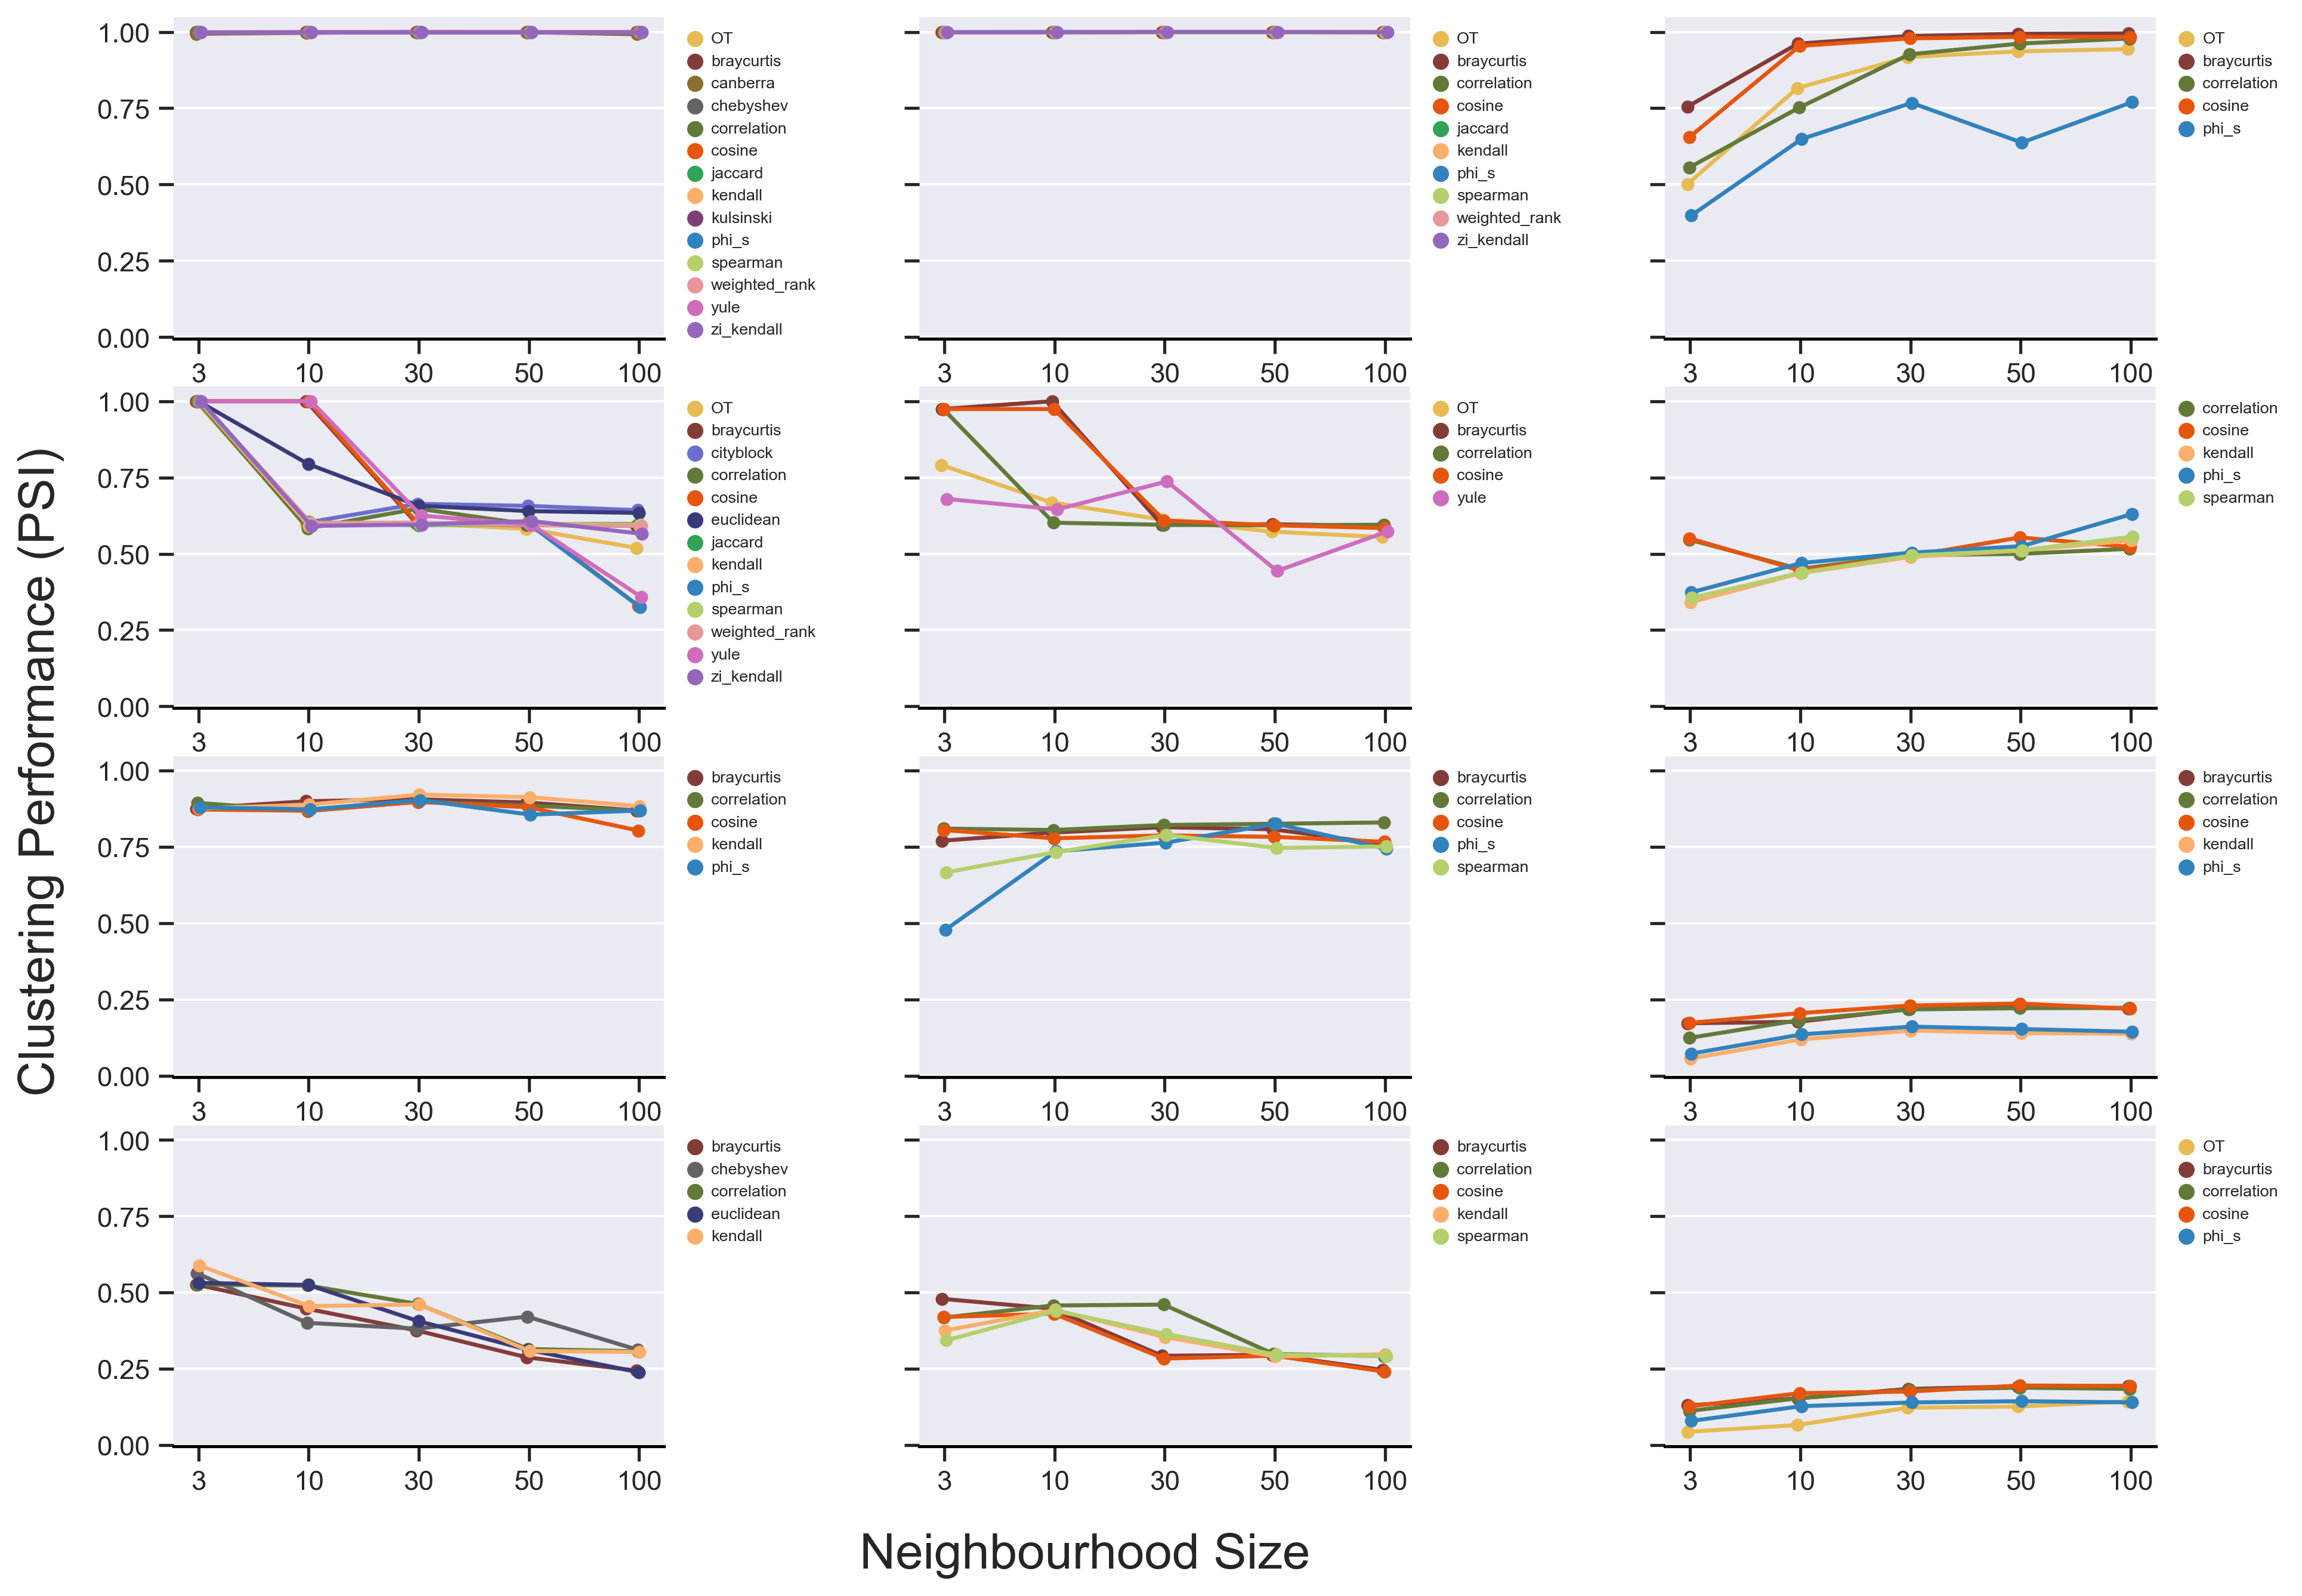

In [16]:
data = filtered_data

order = ['3K_stats','10K_stats','30K_stats','50K_stats','100K_stats']

g = sns.catplot(x = 'k_value',                  
                y = 'Performance', 
                data = data,
                hue = 'Metric',
                col = 'Dataset',
                col_order = all_datasets,
                col_wrap = 3,
                palette = colour_dict,
                s=10,
                kind='point',
                join=True,
                order = order,
                dodge=0.05,
                aspect = 1.8,
                sharey = True,
                height = 2.3,
                scale = 0.6,
                legend_out = False).despine(left=True)


#### To produce individual legends for each subplot: ######
ser_vals = pd.Series(data['Metric'].sort_values().unique())

for axes, (i, d) in zip(g.axes.ravel(), data.groupby(['Dataset'])):
    handles, labels = axes.get_legend_handles_labels()
    
    #subplot aesthetics:
    axes.xaxis.set_tick_params(which='both', labelbottom=True)
    #axes.yaxis.set_tick_params(which='both', labelbottom=True)
    axes.margins(x=0.05)
    
    vals = ser_vals[ser_vals.isin(d['Metric'].unique())]    
    idx = vals.index.tolist()
    
    if len(idx) > 0:
        axes.legend(handles = [handles[i] for i in idx], labels = vals.tolist(), bbox_to_anchor=(1.0, 1.0), prop={'size': 6.5},
                    loc=2,markerscale=1.3, facecolor='white',handletextpad=0, frameon=False)
#############################################################
             
g.fig.subplots_adjust(left=0.09,bottom=0.09,wspace=0.52,hspace=0.15)
g.set_xlabels('')
g.set_ylabels('')
g.set_titles('')

labels = ['3', '10', '30','50','100']
g.set_xticklabels(labels, fontsize=11)

g.fig.supxlabel('Neighbourhood Size',fontsize=20)
g.fig.supylabel('Clustering Performance (PSI)', fontsize=20)

if save is True:
    plt.savefig(f'{fig_dir}Figure_8.png',  bbox_inches = 'tight', dpi=300)